# MLP

### 1.package

In [1]:
import torch
import numpy as np
from obspy import read
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

### 2.load data

In [9]:
# 获取时间窗（P波和S波到达时间）
def get_window_times(Z_hdr):
    before_sec = 0.25
    after_sec = 1.85
    a = Z_hdr.get('a', None)
    t0 = Z_hdr.get('t0', None)
    
    if a is not None and t0 is not None:
        t_p = a  # P波到达时间
        t_s = t0  # S波到达时间
    elif Z_hdr.t3 > 0 and Z_hdr.t4 > 0:
        t_p = Z_hdr.t3  # P波到达时间
        t_s = Z_hdr.t4  # S波到达时间
    elif a is not None and Z_hdr.t4 > 0:
        t_p = a  # P波到达时间
        t_s = Z_hdr.t4  # S波到达时间
    elif Z_hdr.t3 > 0 and t0 is not None:
        t_p = Z_hdr.t3  # P波到达时间
        t_s = t0  # S波到达时间
    else:
        raise ValueError("没有找到有效的P波或S波到达时间。")
    
    # 根据P波或S波确定时间窗
    if Z_hdr.kcmpnm == 'HHZ':  # Z分量
        start_time = int((t_p - before_sec) / Z_hdr.delta)
        end_time = int((t_p + after_sec) / Z_hdr.delta)
    else:  # T分量
        start_time = int((t_s - before_sec) / Z_hdr.delta)
        end_time = int((t_s + after_sec) / Z_hdr.delta)

    return start_time, end_time

# 震级转换为M0
def compute_M0(magnitude):
    Mw = 0.754 * magnitude + 0.88  # Mw ML转换
    return 10 ** (1.5 * Mw + 9.105)

# 函数：读取.lst文件中的每一行，返回对应的文件路径
def read_lst_file(lst_filename):
    """读取.lst文件中的每行路径，返回每行的文件路径（Target waveform, EGF, ASTF）"""
    with open(lst_filename, 'r') as f:
        # 每一行是 "Target_waveform_path EGF_path ASTF_path"
        return [line.strip().split() for line in f.readlines()]

# 函数：加载SAC文件并返回波形数据
def load_sac_file(sac_file):
    """读取SAC文件，返回波形数据"""
    waveform = read(sac_file)[0]
    return waveform

# 函数：补零到最大长度
def pad_to_max_length(waveform_data, max_length):
    """将波形数据补零到最大长度"""
    if len(waveform_data) < max_length:
        padded_data = np.pad(waveform_data, (0, max_length - len(waveform_data)), mode='constant')
    else:
        padded_data = waveform_data
    return padded_data

def normalize_waveform(waveform):
    """对波形进行归一化"""
    # 确保waveform是numpy.ndarray类型
    if isinstance(waveform, np.ndarray):
        # 计算波形的最大值和最小值
        max_value = np.max(waveform)
        min_value = np.min(waveform)
        
        # 计算最大幅度，取最大值和最小值的绝对值
        normalization_coefficient = max(abs(max_value), abs(min_value))
        
        # 归一化
        norm_waveform = waveform / normalization_coefficient
        return normalization_coefficient, norm_waveform
    else:
        raise TypeError("Input waveform should be a numpy ndarray")

# # 数据加载函数：归一化 返回Target Waveform、EGF和ASTF的张量对
# def load_data_pair(target_waveform_path, egf_path, astf_path):
#     """加载一对数据，返回Target、EGF、ASTF张量"""
    
#     # 加载EGF和Target Waveform
#     target_waveform = load_sac_file(target_waveform_path)
#     egf = load_sac_file(egf_path)
#     M0 = compute_M0(egf.stats.sac.mag)
    
#     # 获取时间窗（P波和S波到达时间）
#     start_time, end_time = get_window_times(egf.stats.sac)
    
#     # 截取数据
#     target_waveform_data = target_waveform.data
#     egf_data = egf.data[start_time:end_time]
#     target_waveform_normalization_coefficient, target_waveform_data_normalized = normalize_waveform(target_waveform_data)
#     egf_normalization_coefficient, egf_data_normalized = normalize_waveform(egf_data)
    
#     # 获取较长的长度
#     max_length = max(len(target_waveform_data_normalized), len(egf_data_normalized))
    
#     # 补零
#     # target_waveform_data = pad_to_max_length(target_waveform_data, max_length)
#     egf_data_normalized = pad_to_max_length(egf_data_normalized, max_length)
    
#     # 加载ASTF
#     astf_data = load_sac_file(astf_path).data  # 直接加载ASTF数据
#     astf_data /= M0
#     astf_data_normalized =  astf_data * (egf_normalization_coefficient / target_waveform_normalization_coefficient)
    
#     # 转换为PyTorch张量
#     target_waveform_tensor = torch.tensor(target_waveform_data_normalized, dtype=torch.float32)
#     egf_tensor = torch.tensor(egf_data_normalized, dtype=torch.float32)
#     astf_tensor = torch.tensor(astf_data_normalized, dtype=torch.float32)
    
#     return target_waveform_tensor, egf_tensor, astf_tensor

# 数据加载函数：返回Target Waveform、EGF和ASTF的张量对
def load_data_pair(target_waveform_path, egf_path, astf_path):
    """加载一对数据，返回Target、EGF、ASTF张量"""
    
    # 加载EGF和Target Waveform
    target_waveform = load_sac_file(target_waveform_path)
    egf = load_sac_file(egf_path)
    M0 = compute_M0(egf.stats.sac.mag)
    
    # 获取时间窗（P波和S波到达时间）
    start_time, end_time = get_window_times(egf.stats.sac)
    
    # 截取数据
    target_waveform_data = target_waveform.data
    egf_data = egf.data[start_time:end_time]
    
    # 获取较长的长度
    max_length = max(len(target_waveform_data), len(egf_data))
    
    # 补零
    # target_waveform_data = pad_to_max_length(target_waveform_data, max_length)
    egf_data = pad_to_max_length(egf_data, max_length)
    
    # 加载ASTF
    astf_data = load_sac_file(astf_path).data  # 直接加载ASTF数据
    astf_data /= M0
    
    # 转换为PyTorch张量
    target_waveform_tensor = torch.tensor(target_waveform_data, dtype=torch.float32)
    egf_tensor = torch.tensor(egf_data, dtype=torch.float32)
    astf_tensor = torch.tensor(astf_data, dtype=torch.float32)
    
    return target_waveform_tensor, egf_tensor, astf_tensor

# Dataset类：根据.lst文件加载数据
class SeismicDataset(Dataset):
    def __init__(self, lst_file):
        self.lst_file = lst_file
        
        # 读取路径：每行格式 "Target_waveform_path EGF_path ASTF_path"
        self.data = read_lst_file(self.lst_file)
        
    def __len__(self):
        """返回数据集的大小"""
        return len(self.data)
    
    def __getitem__(self, idx):
        """加载数据并返回对应的目标、EGF和ASTF张量"""
        target_waveform_path, egf_path, astf_path = self.data[idx]
        
        # 加载数据对并返回
        target_waveform_tensor, egf_tensor, astf_tensor = load_data_pair(target_waveform_path, egf_path, astf_path)
        
        return target_waveform_tensor, egf_tensor, astf_tensor

# 加载训练、验证和测试数据
def get_dataloader(train_lst, valid_lst, test_lst, batch_size):
    """返回训练、验证和测试的Dataloader"""
    
    # 创建Dataset
    train_dataset = SeismicDataset(train_lst)
    valid_dataset = SeismicDataset(valid_lst)
    test_dataset = SeismicDataset(test_lst)
    
    # 创建Dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)
    
    return train_loader, valid_loader, test_loader

In [10]:
# 路径
train_lst = "/group/data/dataset_ASTF-net/Target_waveforms/EGFs_train_pairs.lst"
valid_lst = "/group/data/dataset_ASTF-net/Target_waveforms/EGFs_validation_pairs.lst"
test_lst = "/group/data/dataset_ASTF-net/Target_waveforms/EGFs_test_level1_pairs.lst"

batch_size = 1024 * 8 * 8 * 8

# 获取数据加载器
train_loader, valid_loader, test_loader = get_dataloader(train_lst, valid_lst, test_lst, batch_size=batch_size)

Target Waveform Tensor Shape: torch.Size([8192, 510])
EGF Tensor Shape: torch.Size([8192, 510])
ASTF Tensor Shape: torch.Size([8192, 301])


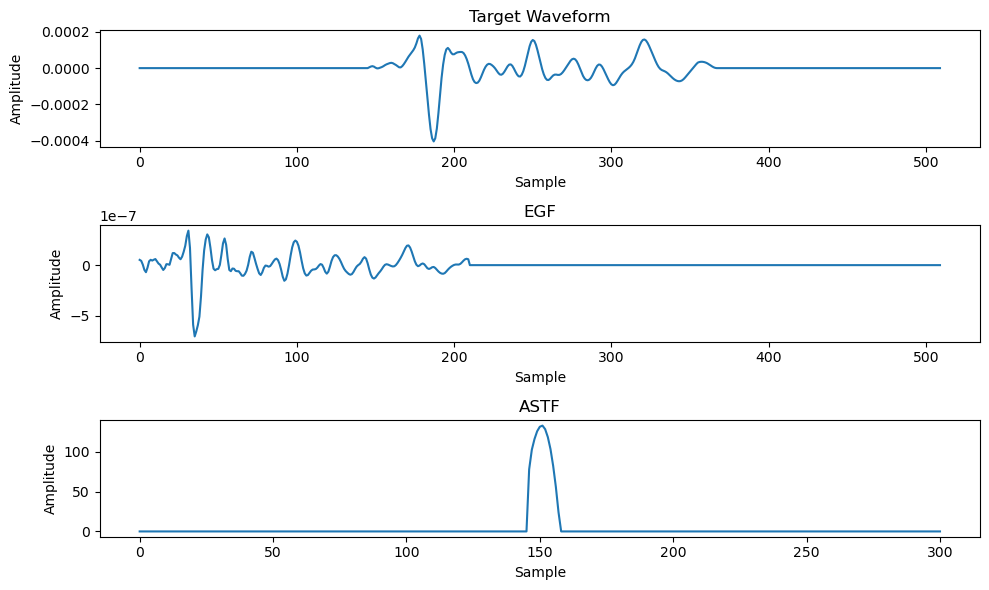

In [6]:
for target_waveform_tensor, egf_tensor, astf_tensor in train_loader:
    print(f"Target Waveform Tensor Shape: {target_waveform_tensor.shape}")
    print(f"EGF Tensor Shape: {egf_tensor.shape}")
    print(f"ASTF Tensor Shape: {astf_tensor.shape}")

    # 选择第一个样本进行绘制（索引为0）
    target_waveform = target_waveform_tensor[0].numpy()  # 将PyTorch Tensor转换为numpy数组
    egf = egf_tensor[0].numpy()
    astf = astf_tensor[0].numpy()

    # 绘制三者
    plt.figure(figsize=(10, 6))

    # 绘制 Target Waveform
    plt.subplot(3, 1, 1)
    plt.plot(target_waveform)
    plt.title('Target Waveform')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

    # 绘制 EGF
    plt.subplot(3, 1, 2)
    plt.plot(egf)
    plt.title('EGF')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

    # 绘制 ASTF
    plt.subplot(3, 1, 3)
    plt.plot(astf)
    plt.title('ASTF')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

    break  # 只读取一个batch进行检查


## MLP model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SeismicMLP(nn.Module):
    def __init__(self, input_dim=510, output_dim=301, hidden_dims=[512, 256, 128]):
        """
        初始化MLP网络
        Args:
            input_dim (int): 输入维度（Target和EGF的每个波形的长度）
            output_dim (int): 输出维度（ASTF的每个波形的长度）
            hidden_dims (list): 隐藏层的维度
        """
        super(SeismicMLP, self).__init__()
        
        # 输入层：拼接Target和EGF，因此输入维度为2 * input_dim
        self.input_layer = nn.Linear(2 * input_dim, hidden_dims[0])
        
        # 隐藏层
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
        
        # 输出层
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, target_waveform, egf):
        """
        前向传播
        Args:
            target_waveform (Tensor): Target Waveform张量，形状为 (batch_size, 510)
            egf (Tensor): EGF张量，形状为 (batch_size, 510)
        Returns:
            astf (Tensor): ASTF张量，形状为 (batch_size, 301)
        """
        # 拼接Target Waveform和EGF作为输入
        x = torch.cat([target_waveform, egf], dim=1)  # 拼接后形状为 (batch_size, 2 * 510)
        
        # 输入层
        x = F.relu(self.input_layer(x))
        
        # 隐藏层
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        
        # 输出层
        astf = self.output_layer(x)  # 输出形状为 (batch_size, 301)
        
        return astf


In [8]:
# 初始化模型
model = SeismicMLP(input_dim=510, output_dim=301, hidden_dims=[512, 256, 128])

# 前向传播
astf_tensor = model(target_waveform_tensor, egf_tensor)

# 输出形状
print("ASTF Tensor Shape:", astf_tensor.shape)


ASTF Tensor Shape: torch.Size([8192, 301])


## Loss Function

In [11]:
def MAPE_loss(y_pred, y_true):
    """
    计算每个样本的平均绝对百分比误差（MAPE）。
    
    Args:
    y_pred (torch.Tensor): 模型的预测值，形状为 [batch_size, 301]
    y_true (torch.Tensor): 真实值，形状为 [batch_size, 301]
    
    Returns:
    torch.Tensor: 平均 MAPE 损失
    """
    # 计算每个点的绝对百分比误差
    mape = torch.abs((y_pred - y_true) / y_true)
    
    # 对每个样本计算平均 MAPE
    mean_mape = torch.mean(mape, dim=1)  # [batch_size, 301] -> [batch_size]
    
    # 计算整个批次的平均 MAPE
    loss = torch.mean(mean_mape)  # [batch_size] -> scalar
    
    return loss


## Train model

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# 模型训练函数
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, device):
    """
    模型训练并可视化
    Args:
        model (nn.Module): 待训练的MLP模型
        train_loader (DataLoader): 训练数据加载器
        val_loader (DataLoader): 验证数据加载器
        num_epochs (int): 训练轮数
        criterion (nn.Module): 损失函数
        optimizer (torch.optim.Optimizer): 优化器
        device (torch.device): 计算设备 (cpu or cuda)
    """
    print(f"Training on device: {device}")
    model = nn.DataParallel(model).to(device)
    best_val_loss = float("inf")
    
    # 用于存储训练和验证损失
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        for target_waveform, egf, astf in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
            target_waveform, egf, astf = target_waveform.to(device), egf.to(device), astf.to(device)
            
            # 前向传播
            optimizer.zero_grad()
            predicted_astf = model(target_waveform, egf)
            
            # 计算损失
            loss = criterion(predicted_astf, astf)
            train_loss += loss.item()
            
            # 反向传播和优化
            loss.backward()
            optimizer.step()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        print(f"Epoch {epoch + 1} - Training Loss: {train_loss:.4f}")
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for target_waveform, egf, astf in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation"):
                target_waveform, egf, astf = target_waveform.to(device), egf.to(device), astf.to(device)
                predicted_astf = model(target_waveform, egf)
                loss = criterion(predicted_astf, astf)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch + 1} - Validation Loss: {val_loss:.4f}")
        
        # 保存最优模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_seismic_model_rMSE.pth")
            print("Model saved with Validation Loss:", best_val_loss)
    
    # 可视化损失
    visualize_loss(train_losses, val_losses)

def visualize_loss(train_losses, val_losses):
    """
    可视化训练和验证损失
    Args:
        train_losses (list): 每个epoch的训练损失
        val_losses (list): 每个epoch的验证损失
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss", marker='o')
    plt.plot(val_losses, label="Validation Loss", marker='x')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()




In [ ]:
# 参数和超参数设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-3
num_epochs = 100
hidden_dims = [512, 256, 128]

# 使用之前完成的数据加载

# 模型、损失函数和优化器
model = SeismicMLP(input_dim=510, output_dim=301, hidden_dims=hidden_dims)
criterion = MAPE_loss  # 使用自定义的相对均方误差损失
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 训练模型
train_model(model, train_loader, valid_loader, num_epochs, criterion, optimizer, device)

Training on device: cuda


Epoch 1/100 - Training:   0%|          | 0/28 [00:00<?, ?it/s]